In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"


fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle, copy
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

# Game of Life CA

In [101]:
2*(9)

18

In [102]:
2**18

262144

In [104]:
jnp.zeros(18, dtype=int)

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [103]:
2*9

18

In [4]:
def conv2d_3x3_sum(x):
    x_padded = jnp.pad(x, pad_width=1, mode='wrap')
    kernel = jnp.ones((3, 3))
    return jax.lax.conv_general_dilated(
            x_padded[None, None, :, :],  # Add batch and channel dimensions
            kernel[None, None, :, :],  # Add input and output channel dimensions
            window_strides=(1, 1),
            padding='VALID',
            dimension_numbers=('NCHW', 'OIHW', 'NCHW'))[0, 0]
    
def step_GoL(state, _, params):
    state = state.astype(float)
    n_neighbors = conv2d_3x3_sum(state) - state
    update_idx = state * 9 + n_neighbors
    next_state = params[update_idx.astype(int)]
    return next_state, state
params_gol = jnp.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])
x_gol_glider = jnp.zeros((32, 32), dtype=int)
x_gol_glider = x_gol_glider.at[:3, :3].set(jnp.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]]))

2024-08-02 05:24:38.232351: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
rng = jax.random.PRNGKey(0)

In [6]:
# x = jax.random.randint(rng, shape=(8, 8), minval=0, maxval=2).astype(float)

In [7]:
y, vid = jax.lax.scan(partial(step_GoL, params=params_gol), x_gol_glider, None, length=32)

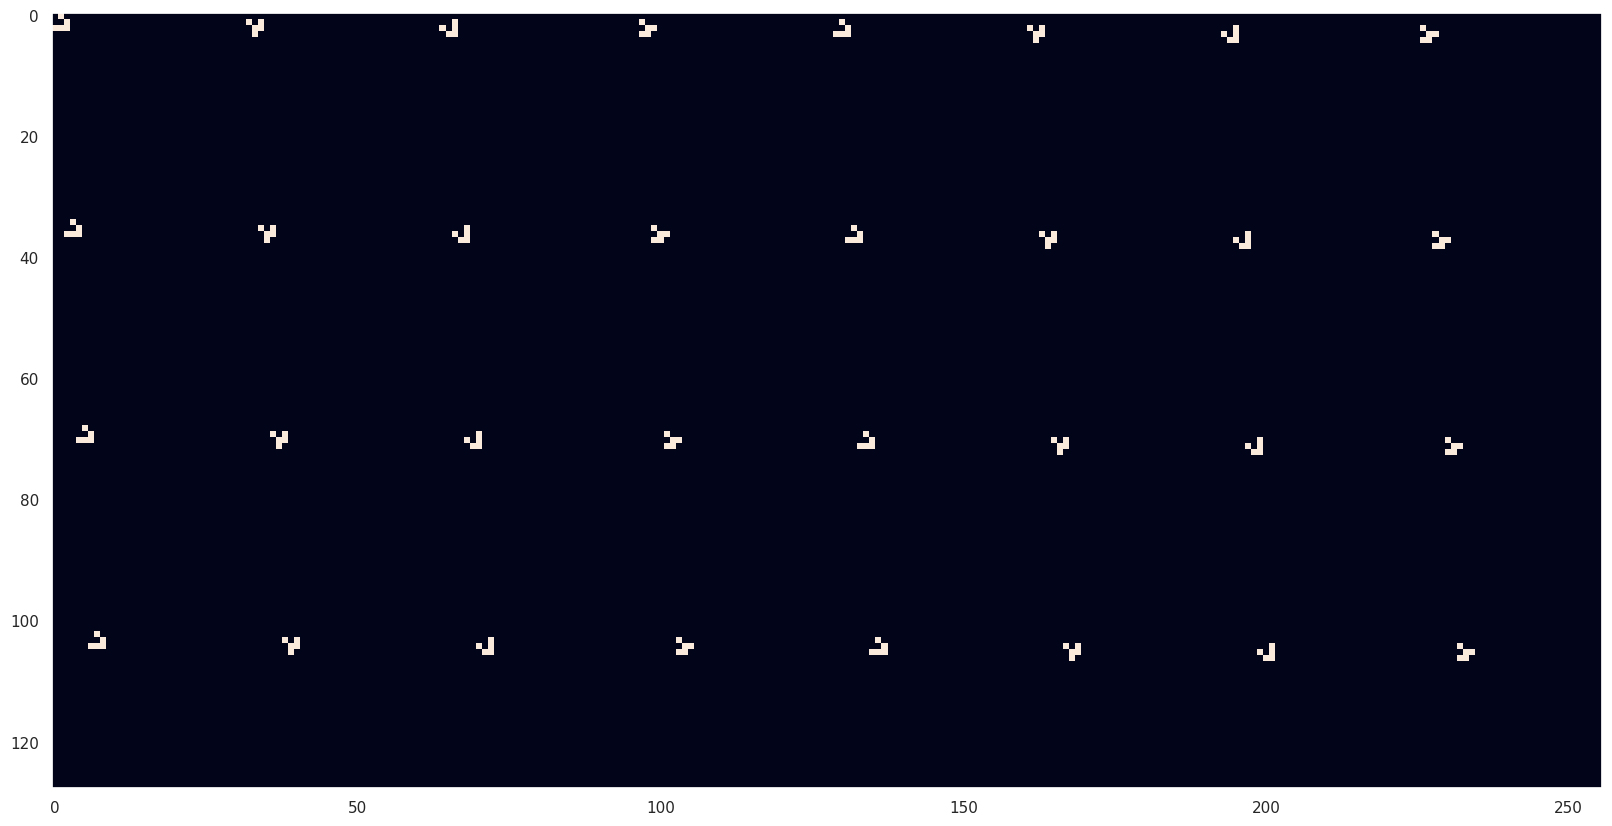

In [8]:
plt.figure(figsize=(20, 20))
plt.imshow(rearrange(vid, "(R C) H W -> (R H) (C W)", R=4))
plt.grid(False)
plt.show()

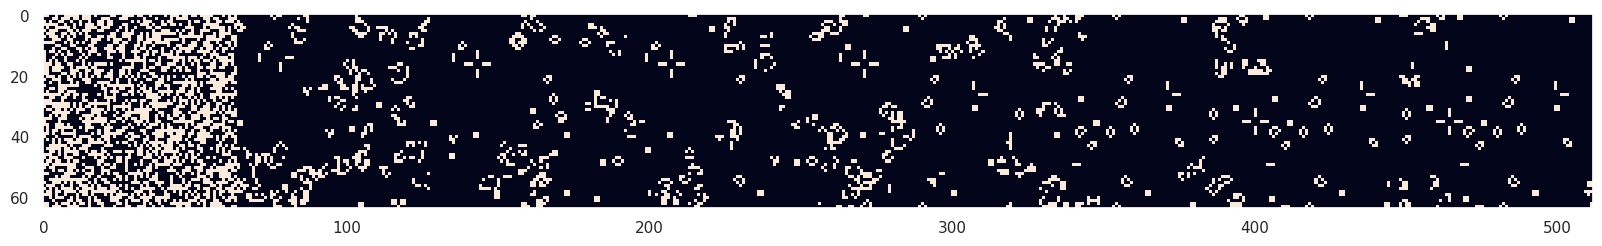

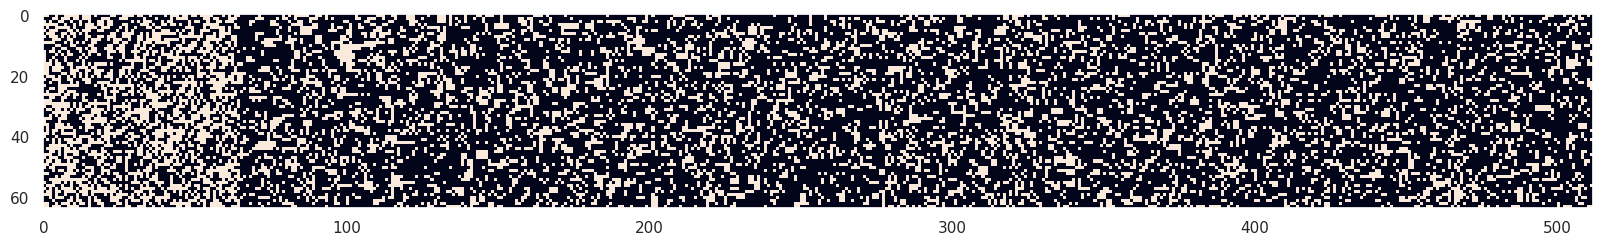

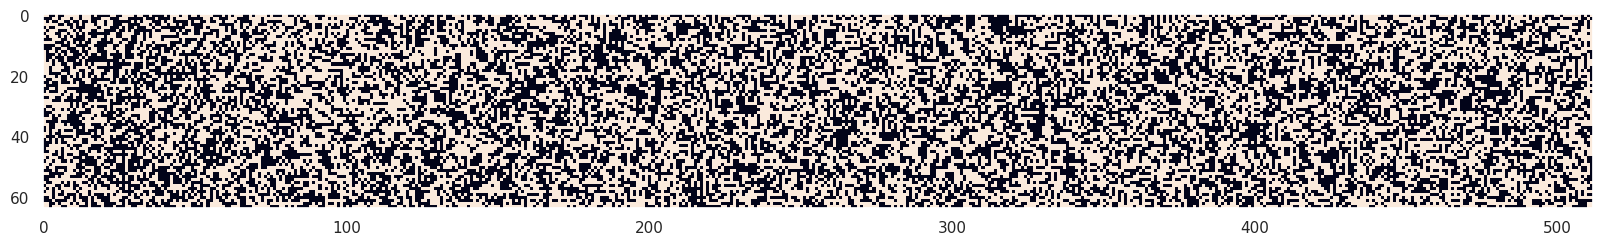

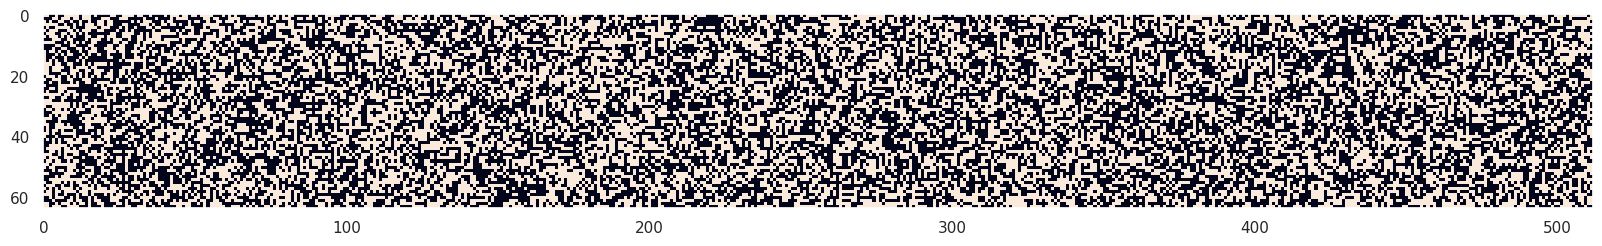

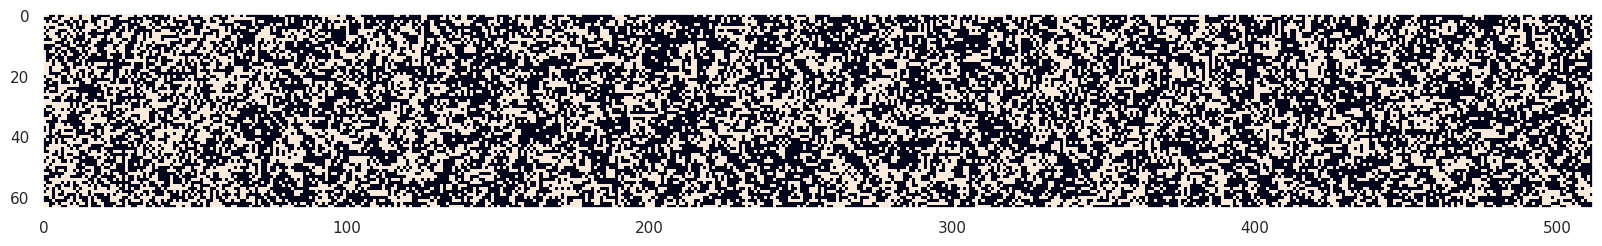

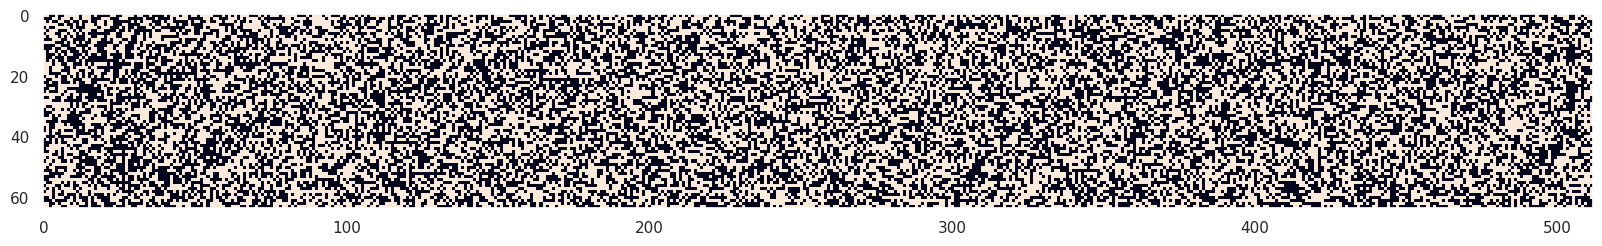

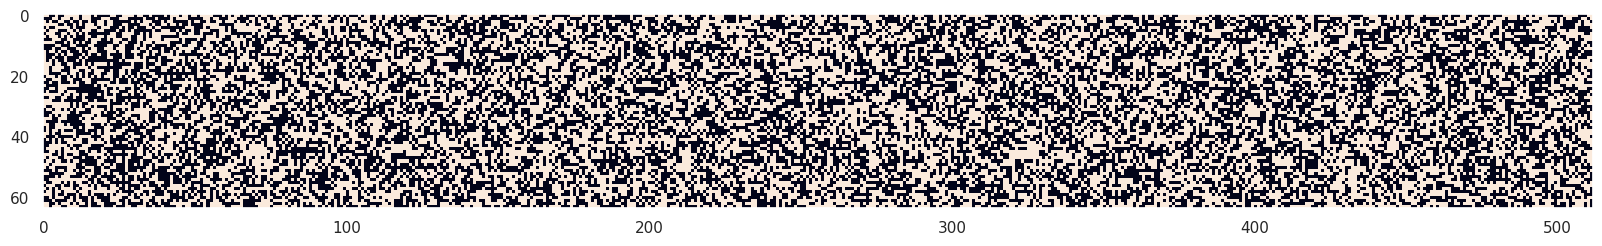

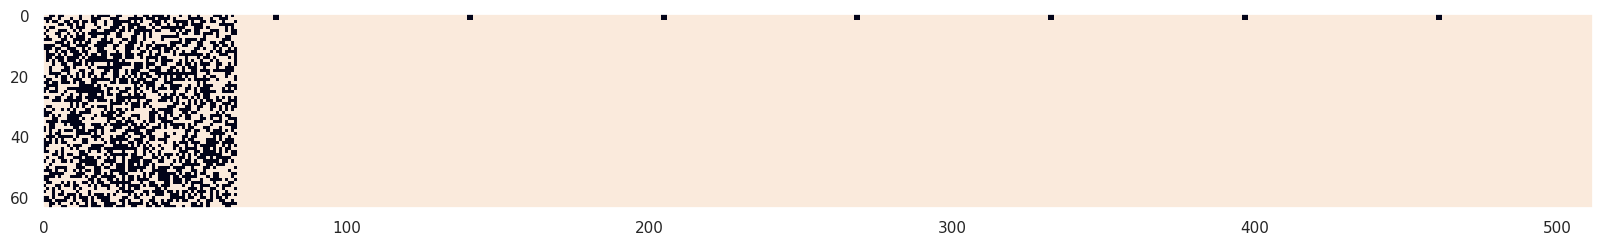

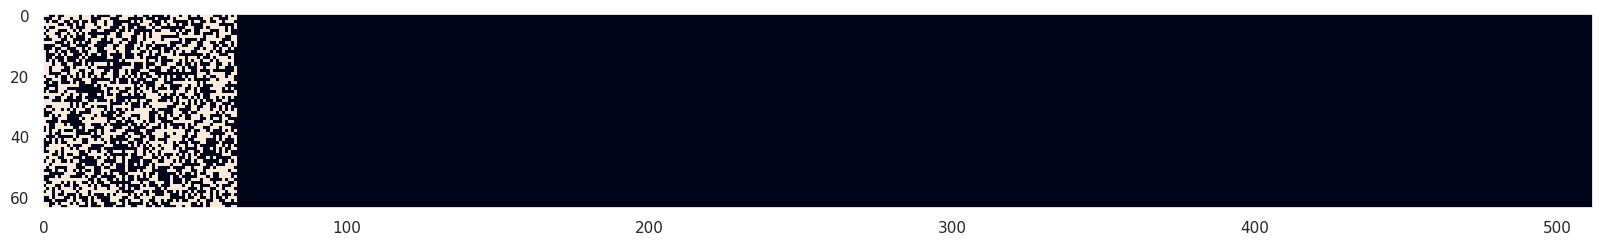

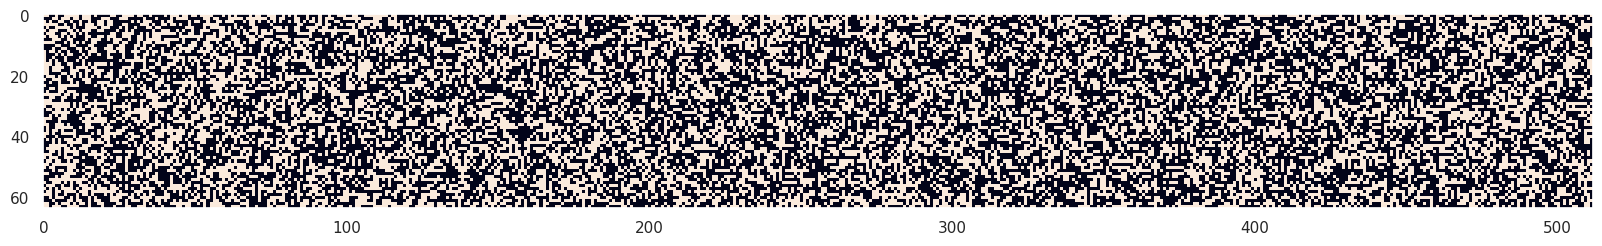

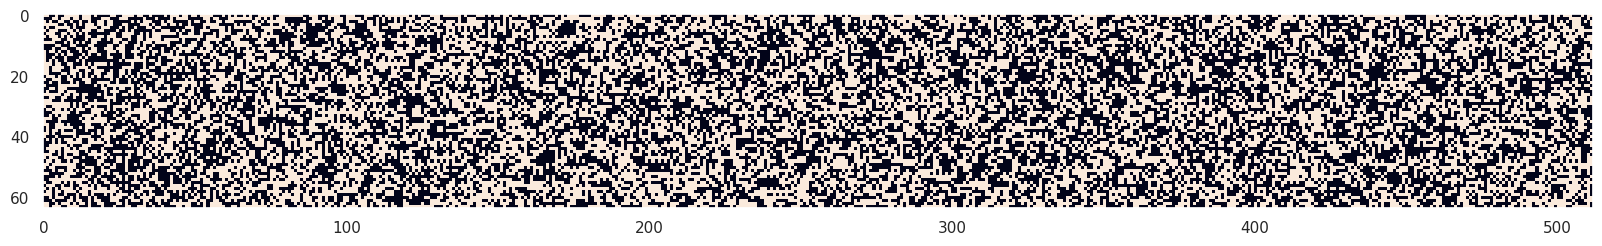

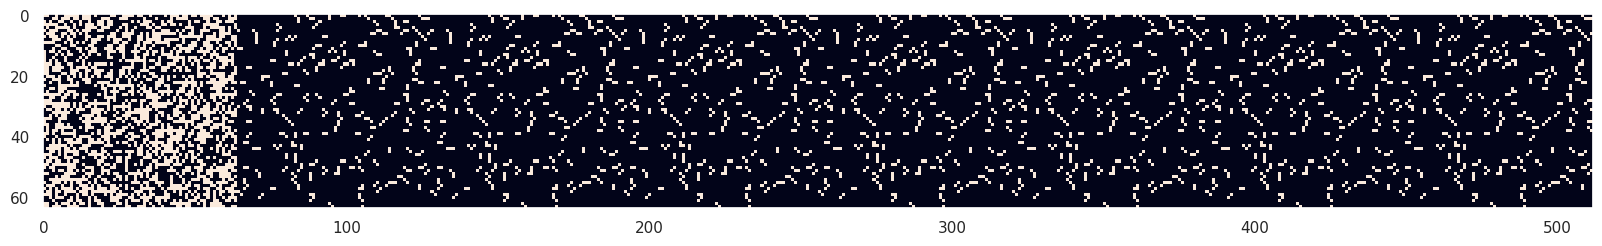

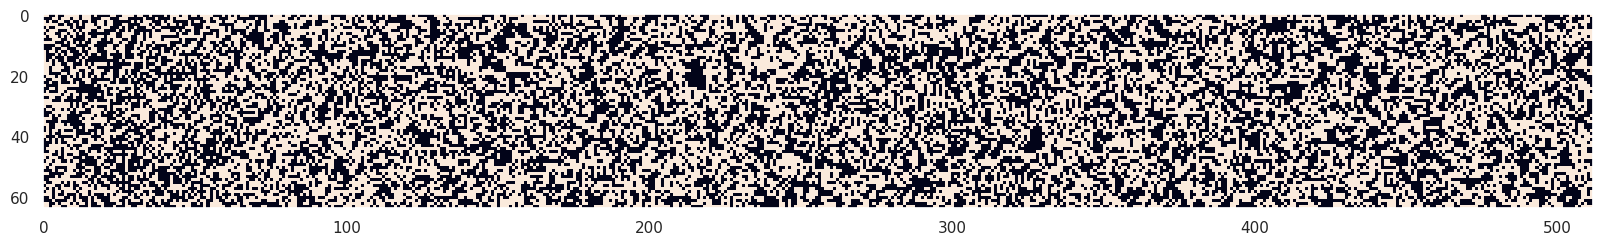

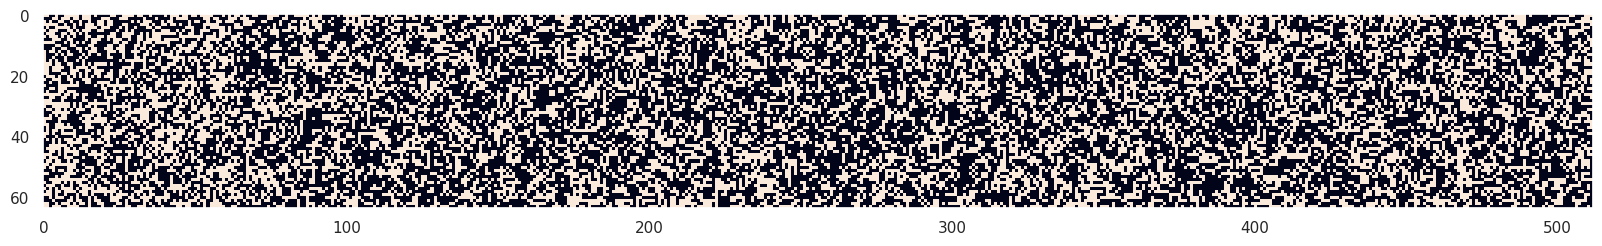

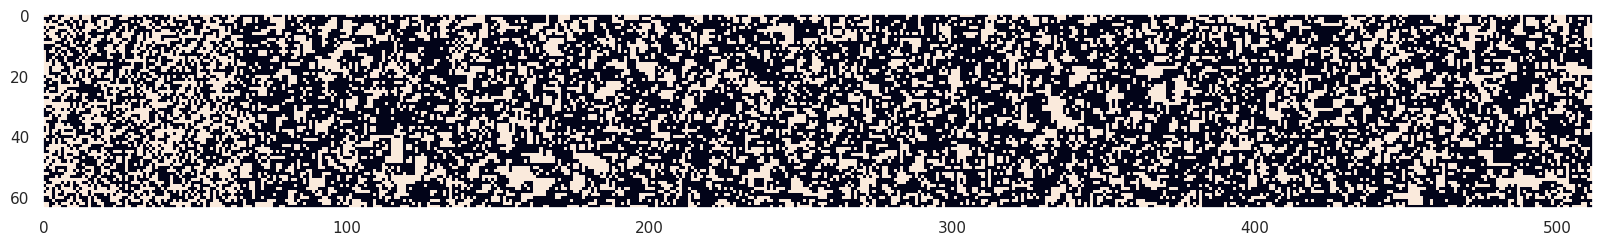

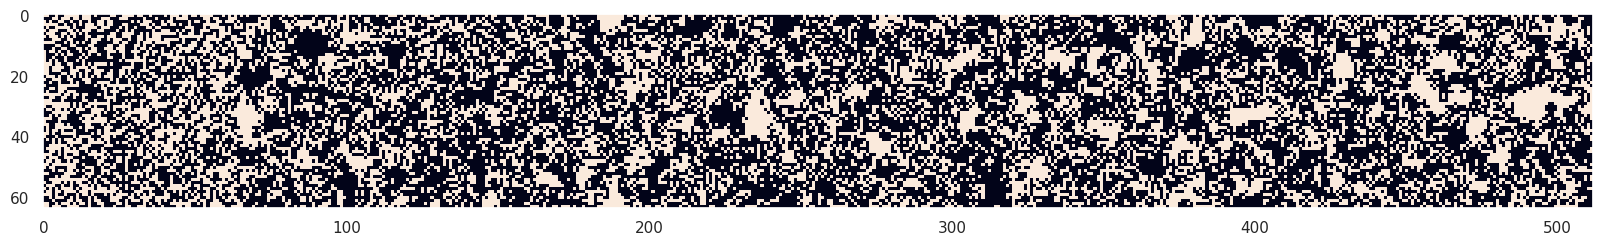

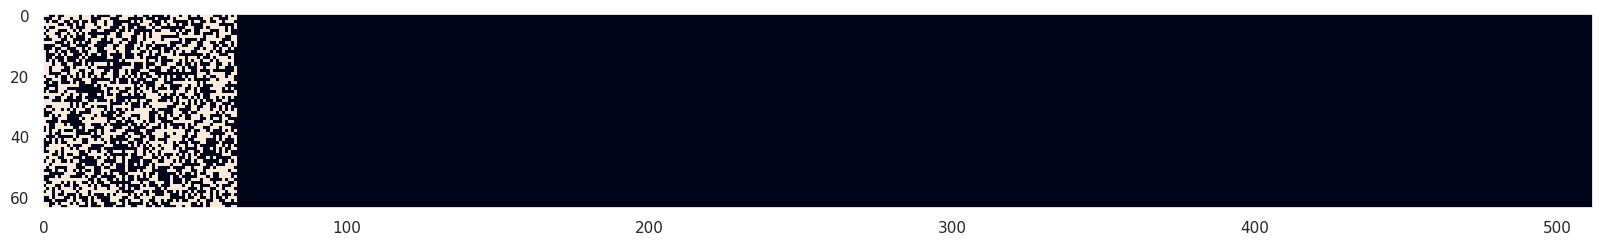

In [9]:
rng = jax.random.PRNGKey(1)
x = jax.random.randint(rng, shape=(64, 64), minval=0, maxval=2)

_, vid = jax.lax.scan(partial(step_GoL, params=params_gol), x, None, length=512)
plt.figure(figsize=(20, 5))
plt.imshow(rearrange(vid[::64], "(R C) H W -> (R H) (C W)", R=1)); plt.grid(False)
plt.show()

for i in range(16):
    rng = jax.random.PRNGKey(i)
    params = jax.random.randint(rng, shape=(18, ), minval=0, maxval=2)
    _, vid = jax.lax.scan(partial(step_GoL, params=params), x, None, length=512)
    plt.figure(figsize=(20, 5))
    plt.imshow(rearrange(vid[::64], "(R C) H W -> (R H) (C W)", R=1)); plt.grid(False)
    plt.show()
    

In [7]:
from clip_jax import MyFlaxCLIP
clip_model = MyFlaxCLIP()

In [185]:
bs = 128*8
bs = 128
grid_size = 64
n_steps = 512
n_steps_clip = n_steps//8

resize_fn = partial(jax.image.resize, shape=(224, 224), method='nearest')

In [186]:
rng = jax.random.PRNGKey(0)
sparsity = jnp.linspace(.05, .4, num=bs)
state_init = jax.random.uniform(rng, shape=(bs, grid_size, grid_size), minval=0, maxval=1)
state_init = jnp.floor(state_init+sparsity[:, None, None]).astype(int)

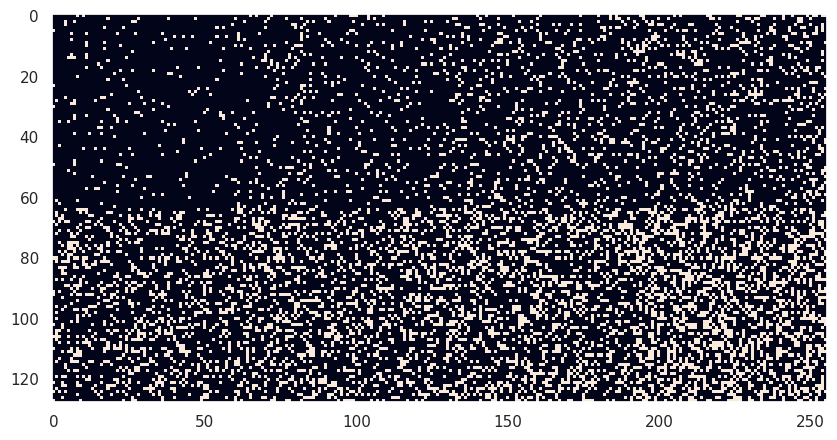

In [187]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(state_init[::state_init.shape[0]//8], "(R C) H W -> (R H) (C W)", R=2))
plt.grid(False)

In [238]:
def conv2d_3x3_sum(x):
    x_padded = jnp.pad(x, pad_width=1, mode='wrap')
    kernel = jnp.ones((3, 3))
    return jax.lax.conv_general_dilated(
            x_padded[None, None, :, :],  # Add batch and channel dimensions
            kernel[None, None, :, :],  # Add input and output channel dimensions
            window_strides=(1, 1),
            padding='VALID',
            dimension_numbers=('NCHW', 'OIHW', 'NCHW'))[0, 0]
def step_ca(state, _, params):
    state_f = state.astype(float)
    n_neighbors = conv2d_3x3_sum(state_f) - state_f
    update_idx = state_f * 9 + n_neighbors
    next_state = params[update_idx.astype(int)]
    return next_state, state
    
params_gol = jnp.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])
x_gol_glider = jnp.zeros((32, 32), dtype=int)
x_gol_glider = x_gol_glider.at[:3, :3].set(jnp.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]]))

def unroll_ca(state_init, params, n_steps=512):
    state_final, state_vid = jax.lax.scan(partial(step_ca, params=params), state_init, None, length=n_steps)
    return state_vid


@jax.jit
def eval_clip_complexity(params):
    state_vid = jax.vmap(partial(unroll_ca, params=params, n_steps=n_steps))(state_init)
    vid_clip = jax.vmap(jax.vmap(resize_fn))( state_vid[:, ::n_steps_clip].astype(jnp.float32) )
    vid_clip = repeat(vid_clip, "... -> ... 3")
    z_img = jax.vmap(jax.vmap(clip_model.embed_img))(vid_clip)
    scores = (z_img@z_img.mT)
    scores_tril = jax.vmap(partial(jnp.tril, k=-1))(scores)
    similarities = (scores_tril).max(axis=-1)
    return dict(state_vid=state_vid, z_img=z_img, scores=scores, similarities=similarities)

In [239]:
data = []

params = params_gol
similarities = eval_clip_complexity(params)['similarities'].mean(axis=0)
data.append(dict(params=params, similarities=similarities))

for i in tqdm(range(10000)):
    rng = jax.random.PRNGKey(i)
    params = jax.random.randint(rng, shape=(18, ), minval=0, maxval=2)
    similarities = eval_clip_complexity(params)['similarities'].mean(axis=0)
    data.append(dict(params=params, similarities=similarities))
    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [240]:
data = jax.tree.map(lambda *x: jnp.stack(x, axis=0), *data)

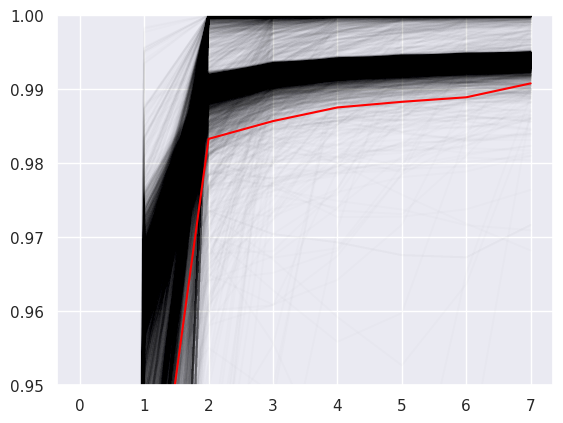

In [242]:
plt.plot(data['similarities'].T, c='black', alpha=0.01)
plt.plot(data['similarities'][0], c='red', alpha=1.0)
plt.ylim(0.95, 1.)
plt.show()

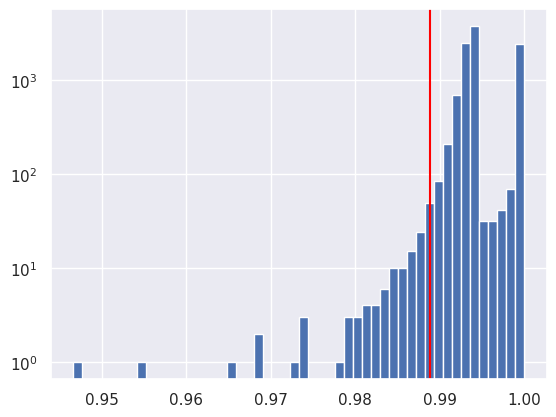

In [243]:
a = data['similarities'][:, 4:].mean(axis=-1)
plt.hist(a, bins=50);
plt.yscale('log')
plt.axvline(a[0], color='red', )

In [248]:
a[0]

Array(0.98887, dtype=float32)

In [250]:
(a<a[0]).sum()

Array(115, dtype=int32)

  0%|          | 0/20 [00:00<?, ?it/s]

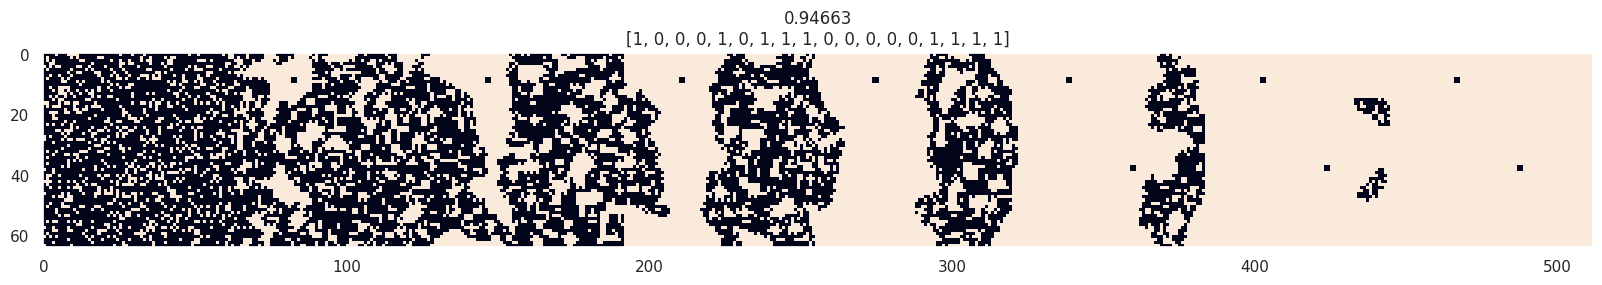

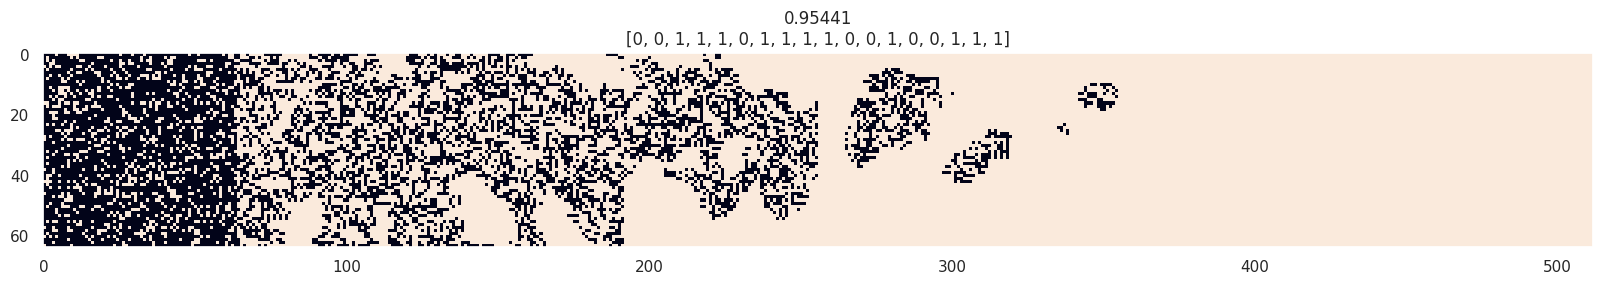

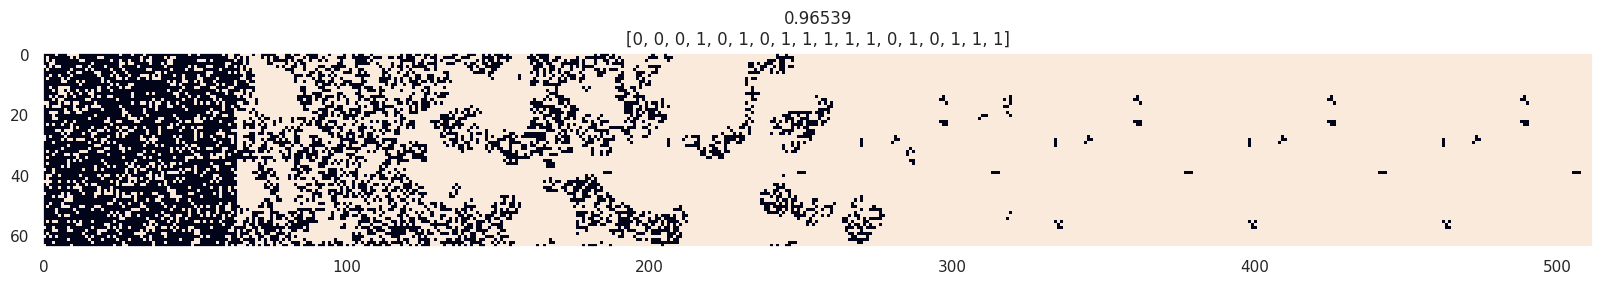

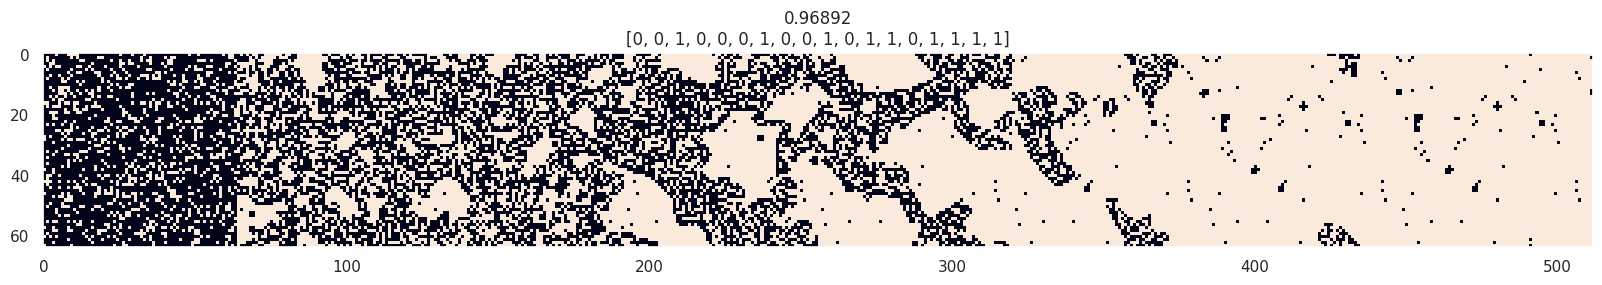

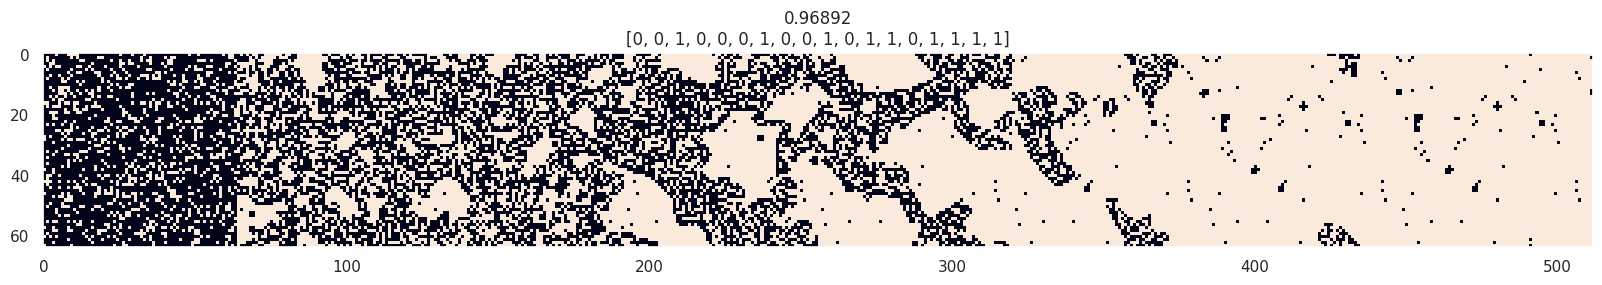

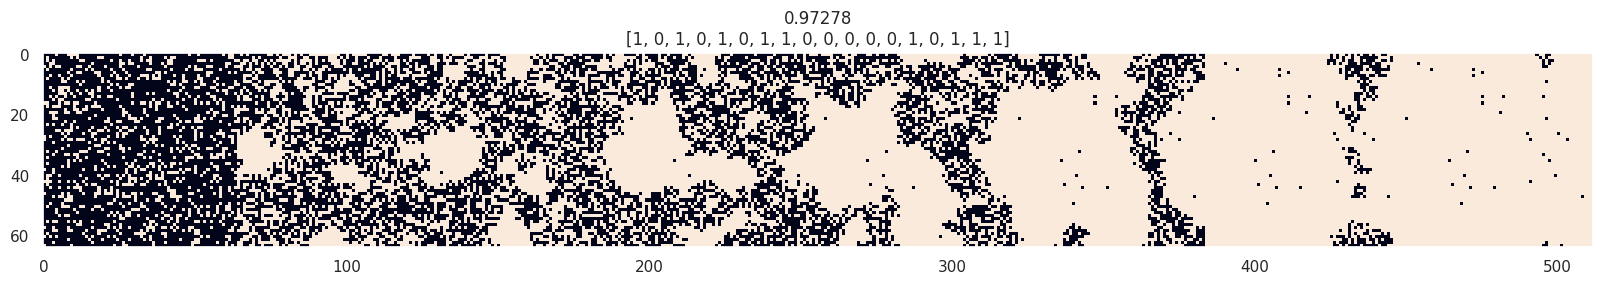

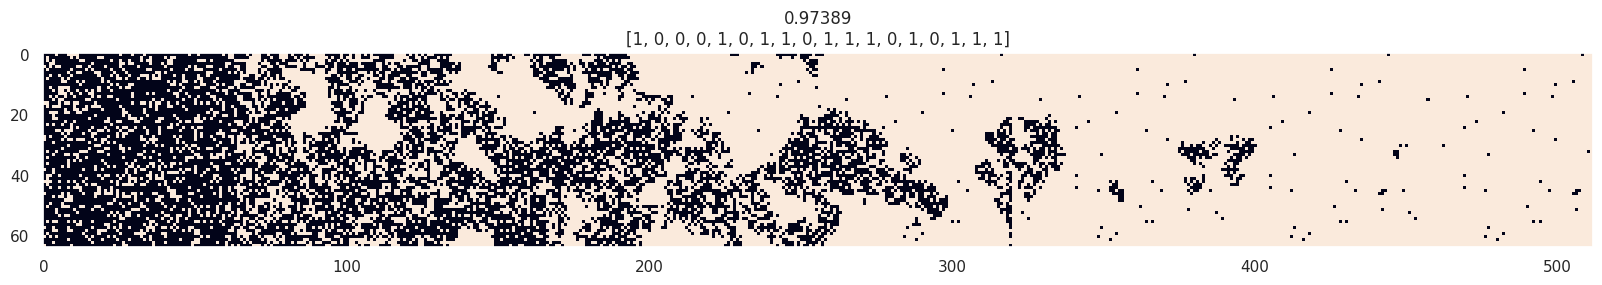

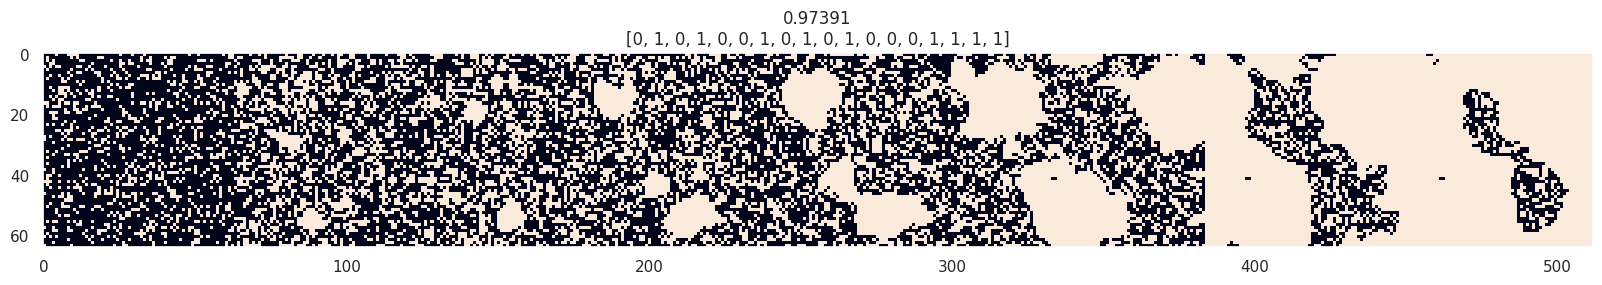

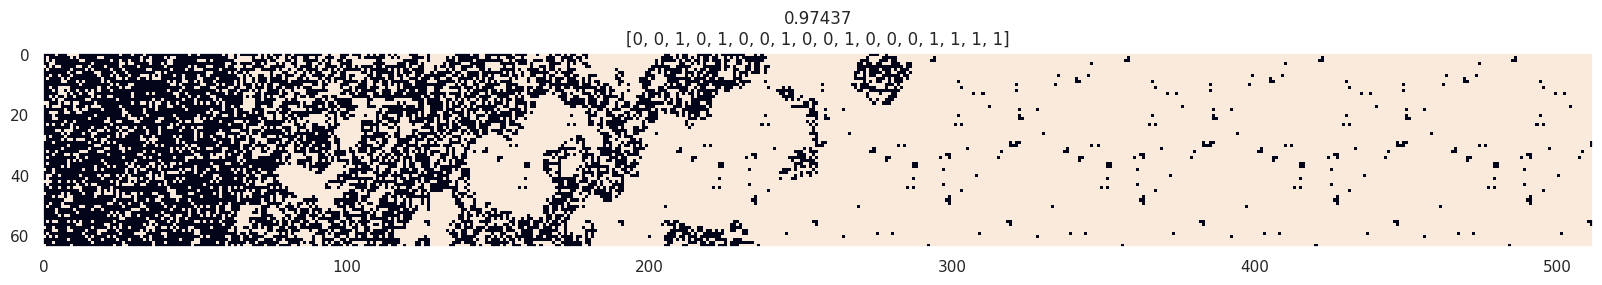

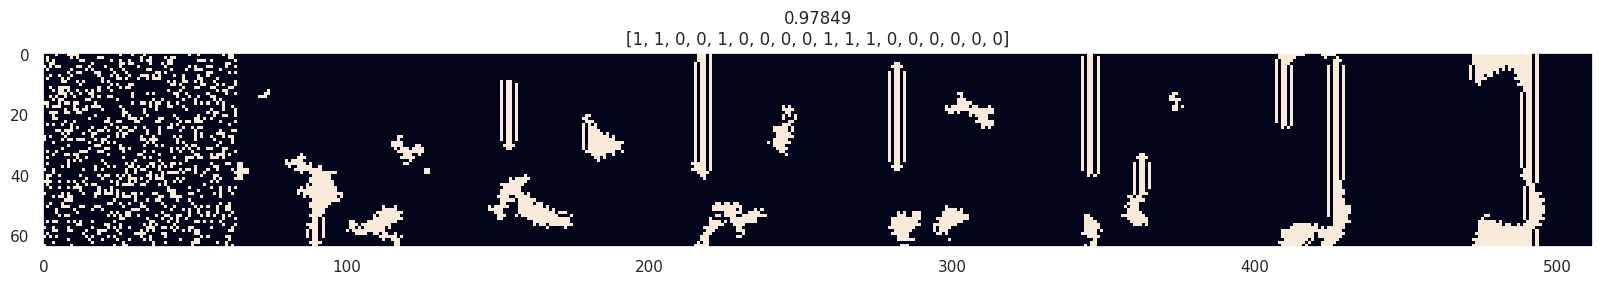

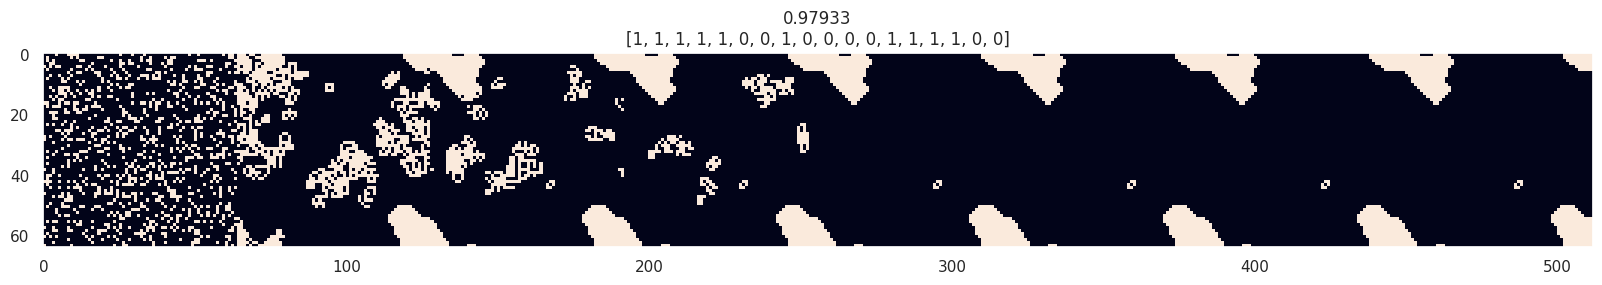

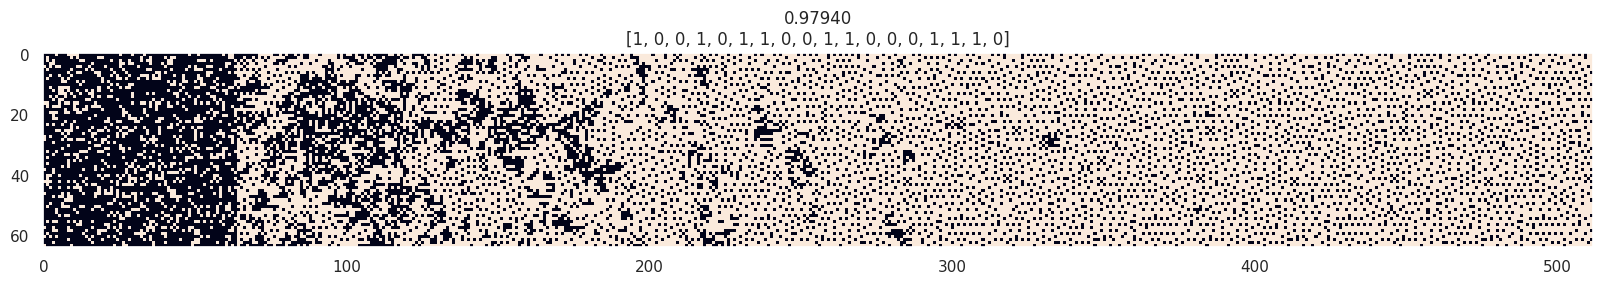

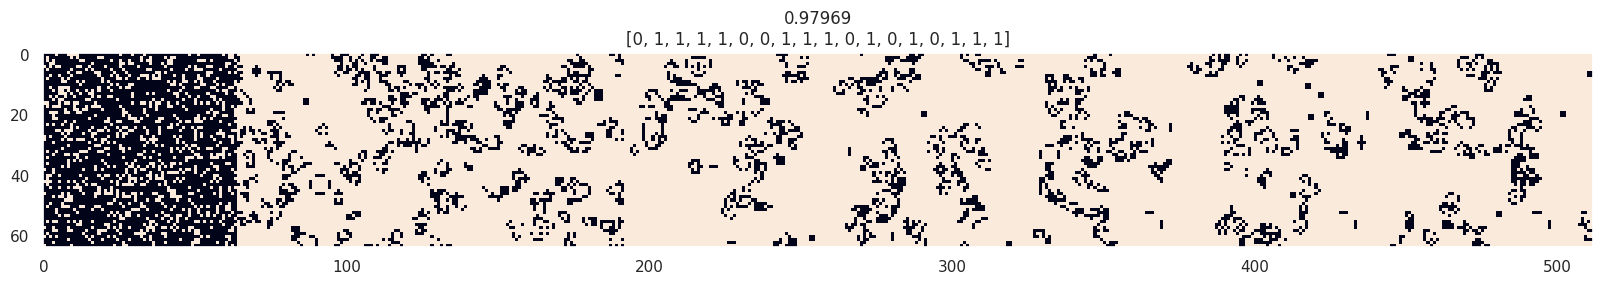

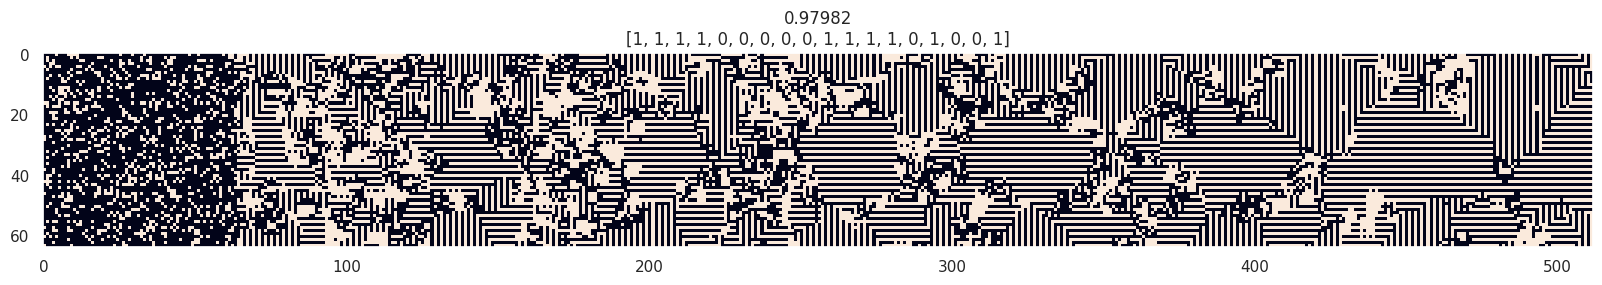

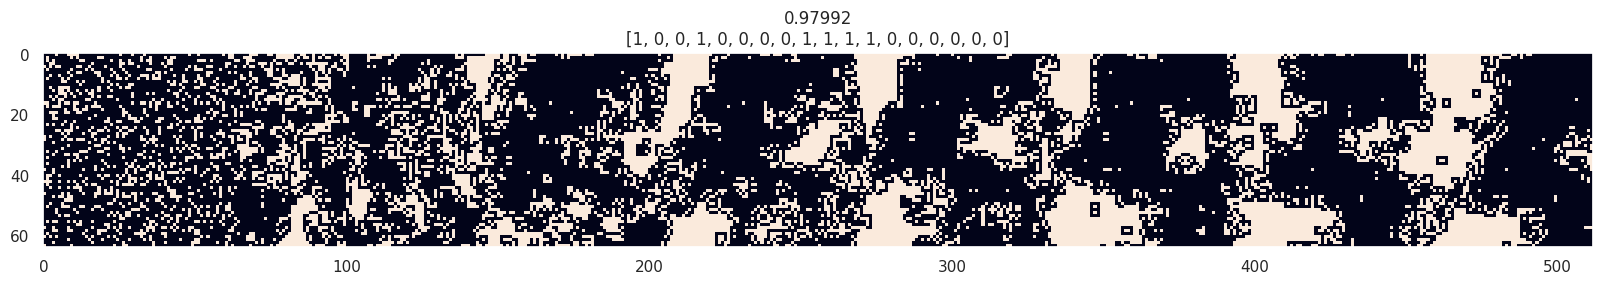

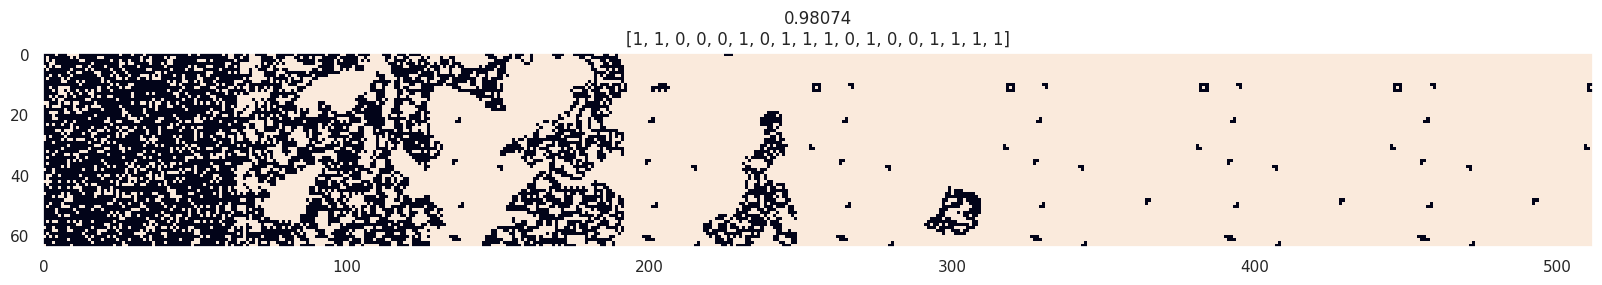

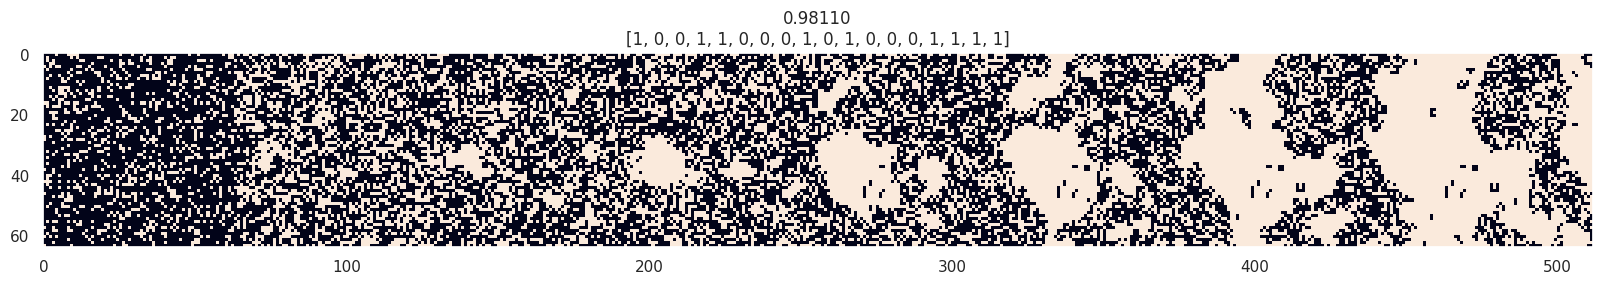

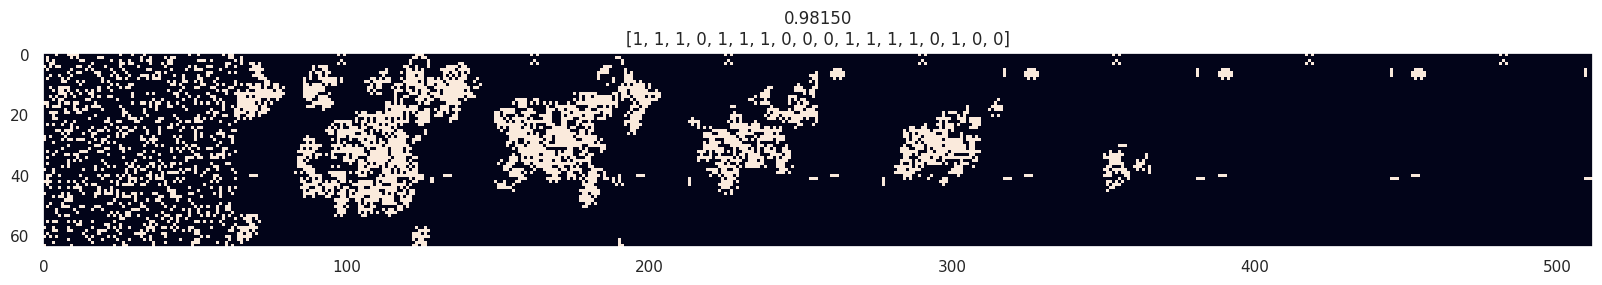

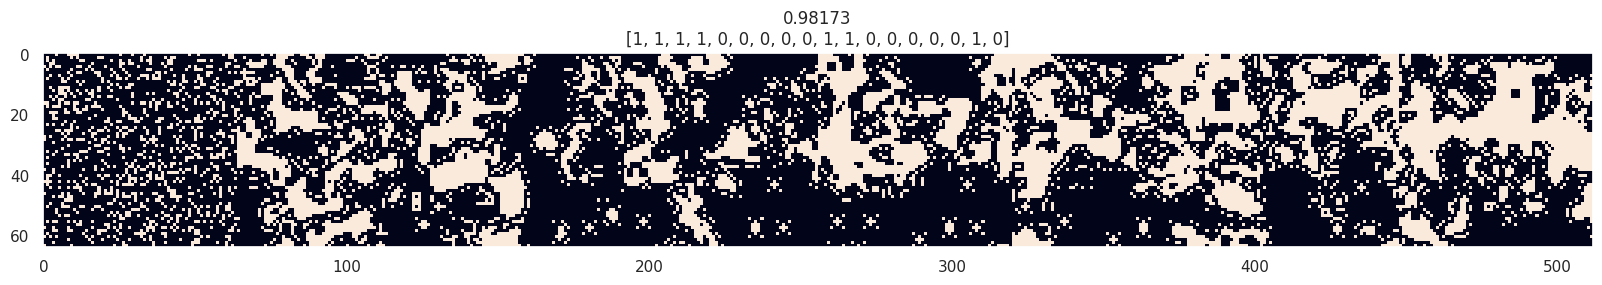

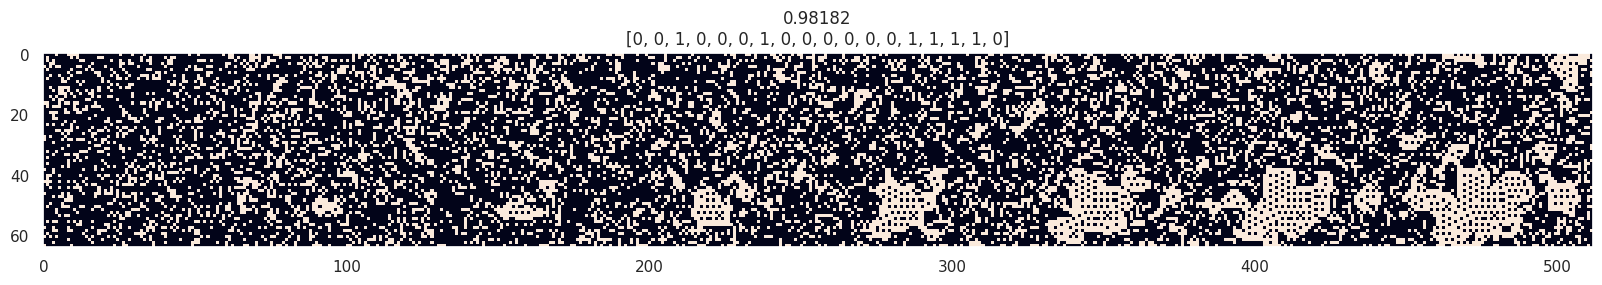

In [251]:
for i in tqdm(a.argsort()[:20]):
    state_vid = eval_clip_complexity(data['params'][i])['state_vid']

    plt.figure(figsize=(20, 5))
    plt.imshow(rearrange(state_vid[64, ::64], "(R C) H W -> (R H) (C W)", R=1))
    plt.grid(False)
    plt.title(f"{a[i].item():.5f}\n{data['params'][i].tolist()}")
    plt.show()

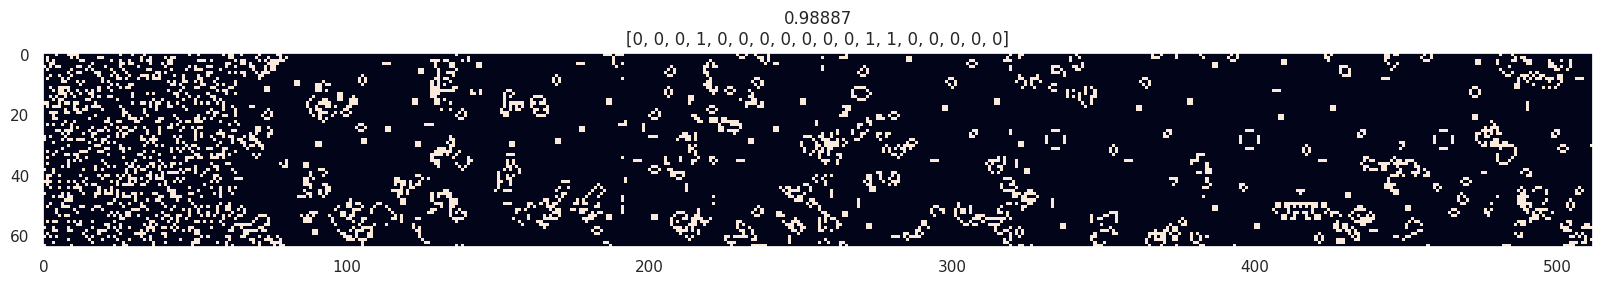

In [253]:
i = 0
state_vid = eval_clip_complexity(data['params'][i])['state_vid']
plt.figure(figsize=(20, 5))
plt.imshow(rearrange(state_vid[64, ::64], "(R C) H W -> (R H) (C W)", R=1))
plt.grid(False)
plt.title(f"{a[i].item():.5f}\n{data['params'][i].tolist()}")
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

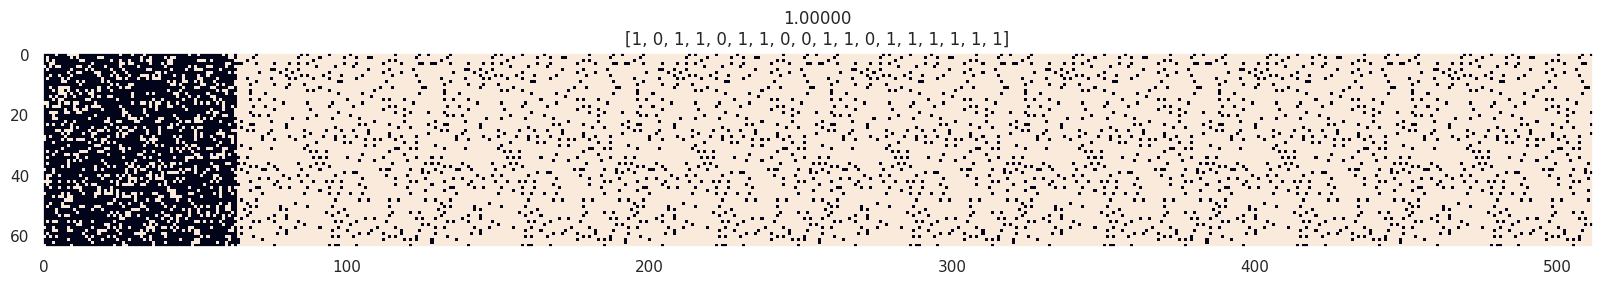

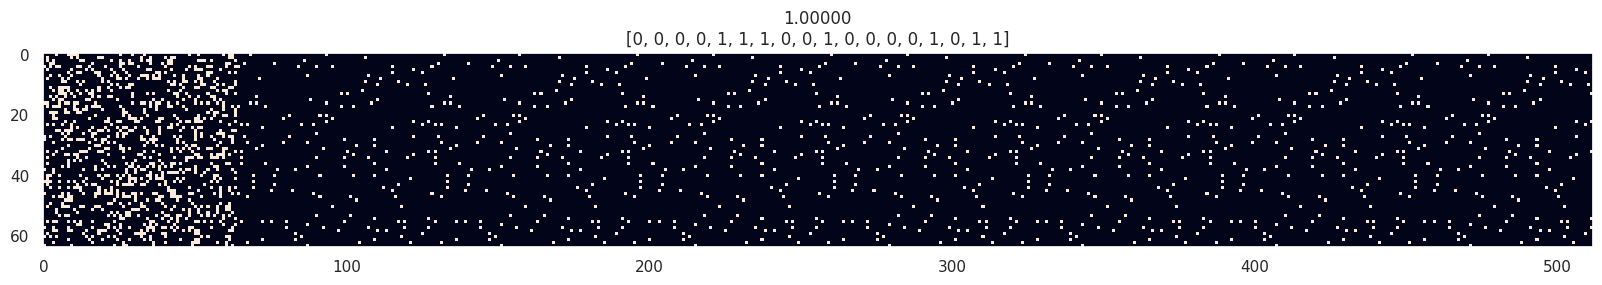

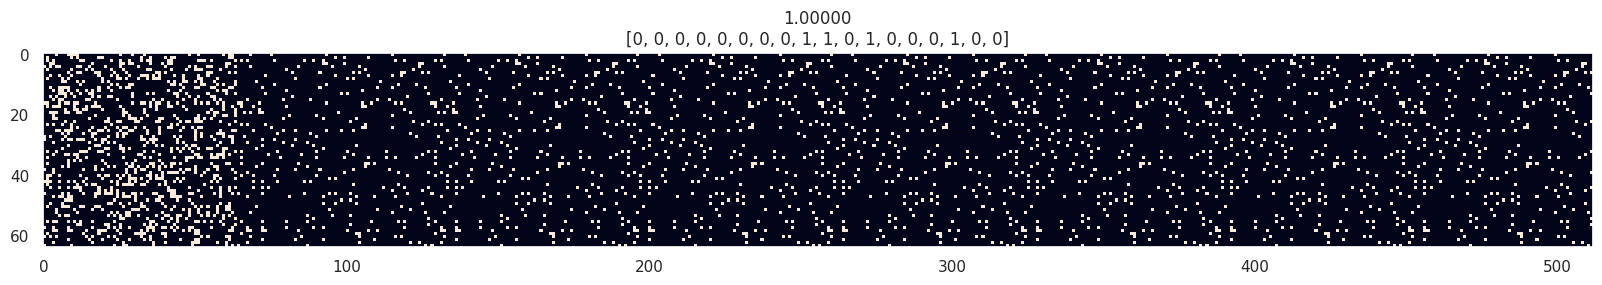

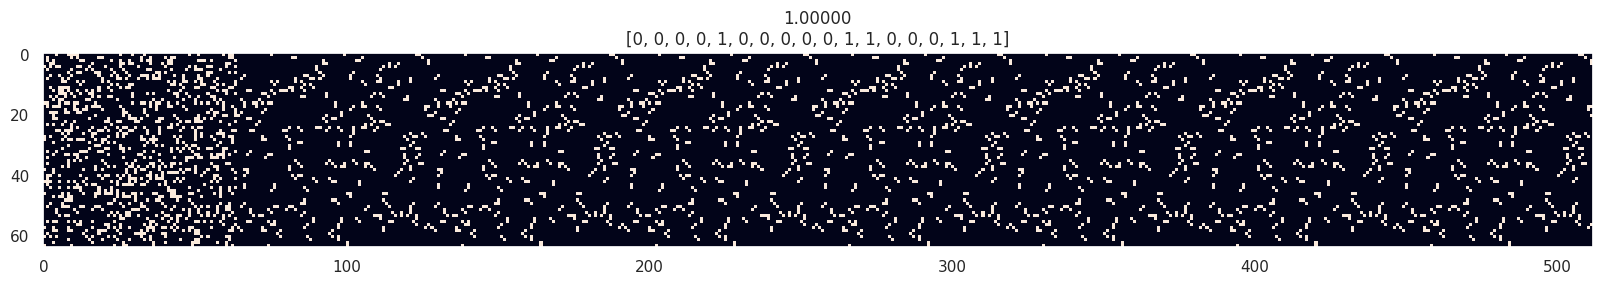

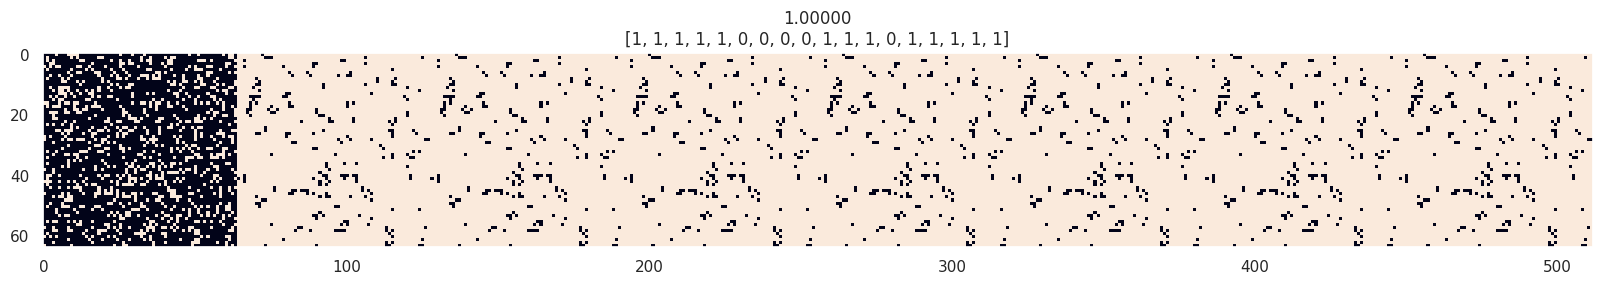

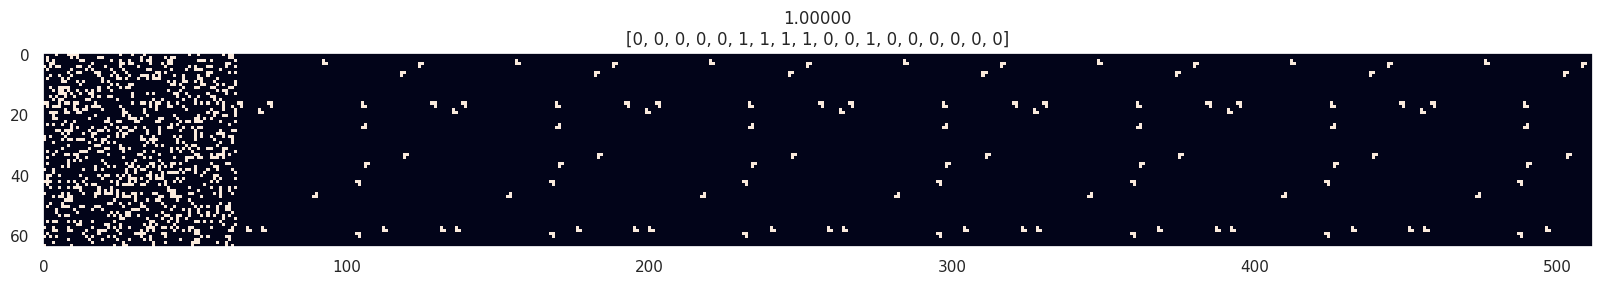

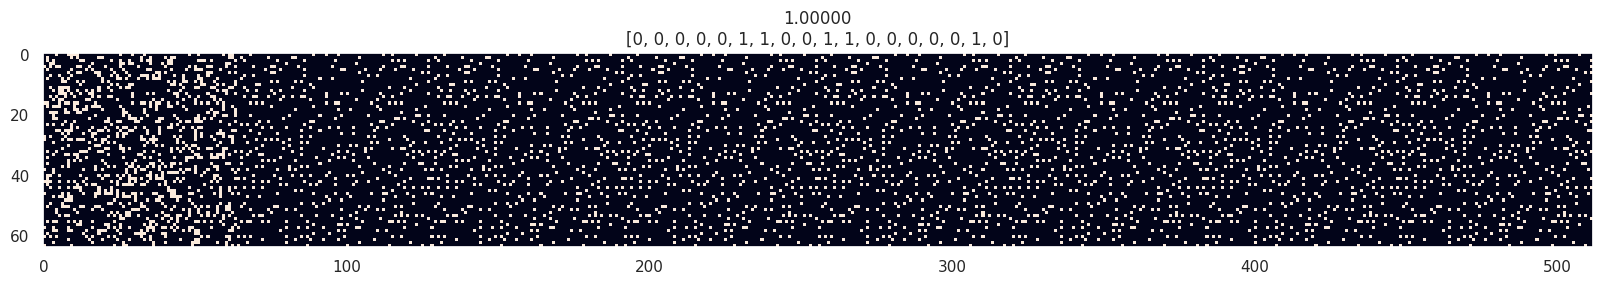

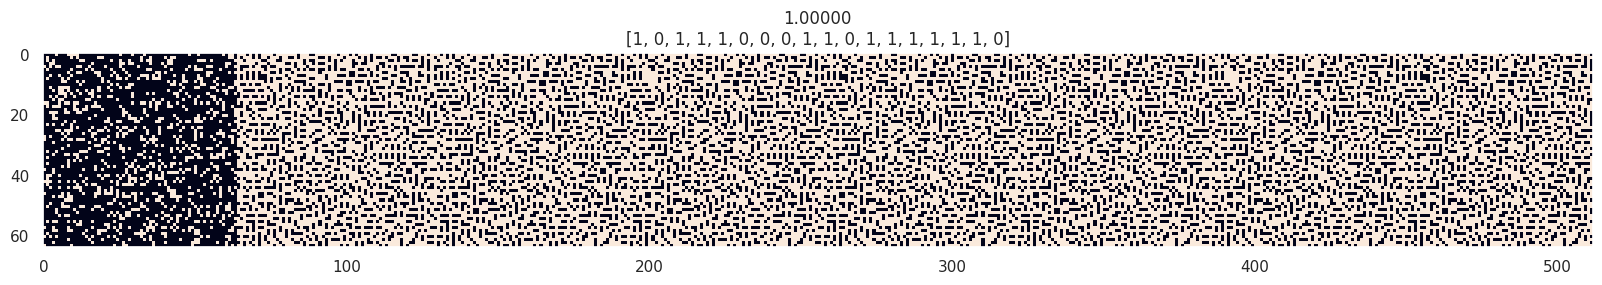

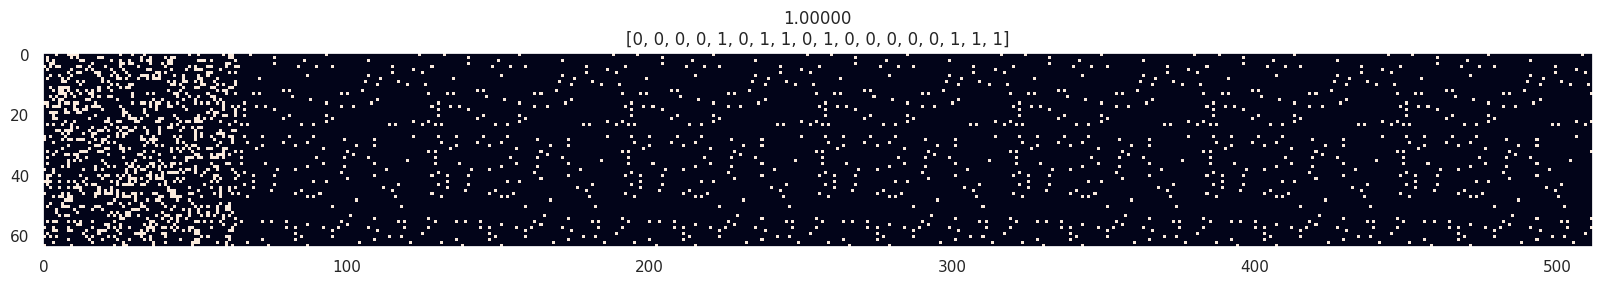

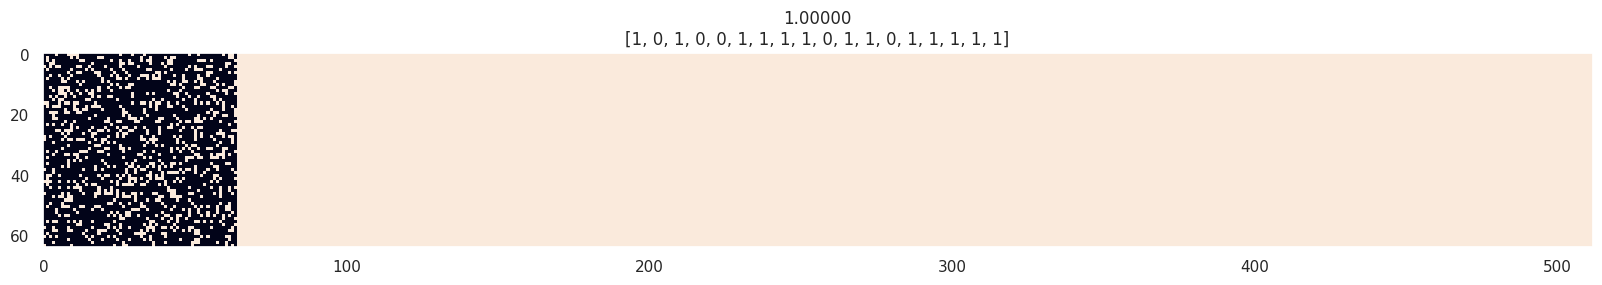

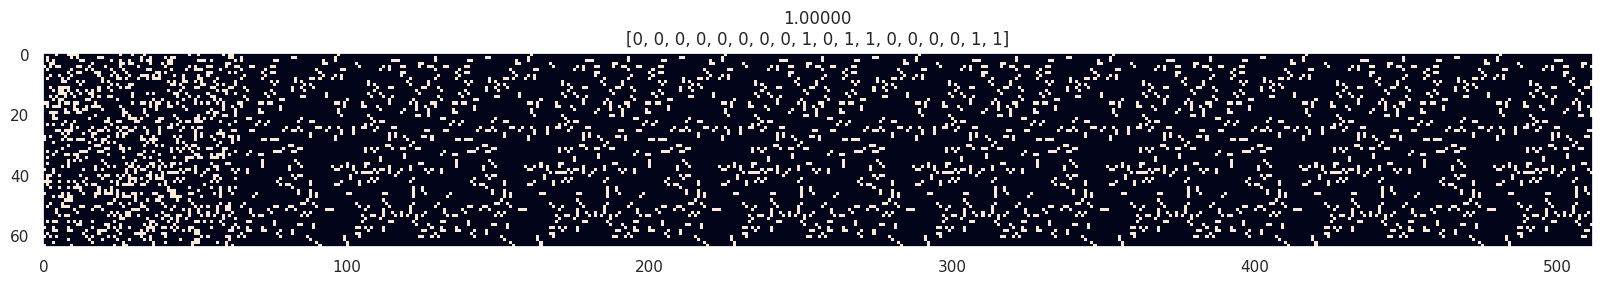

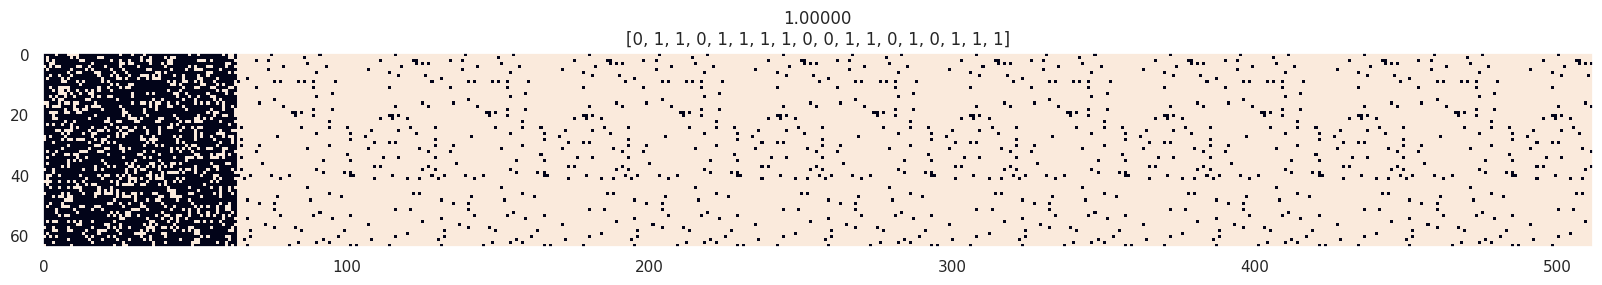

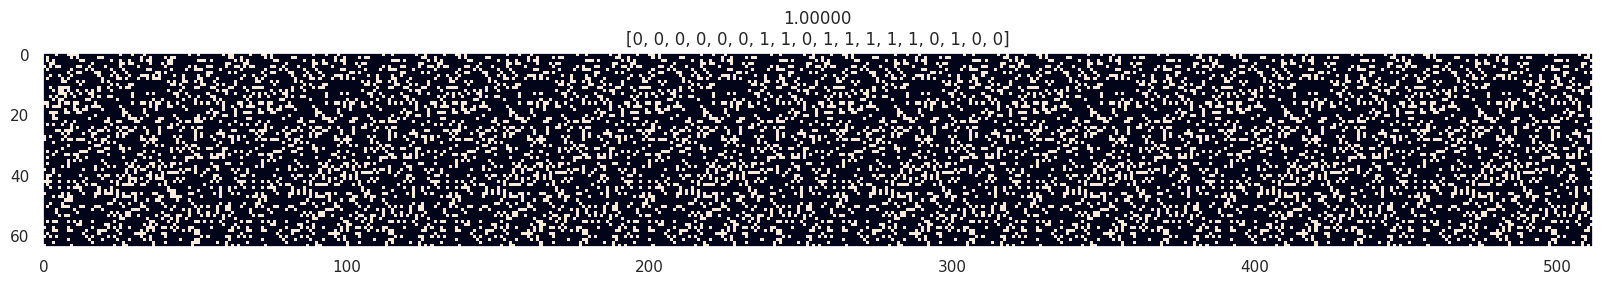

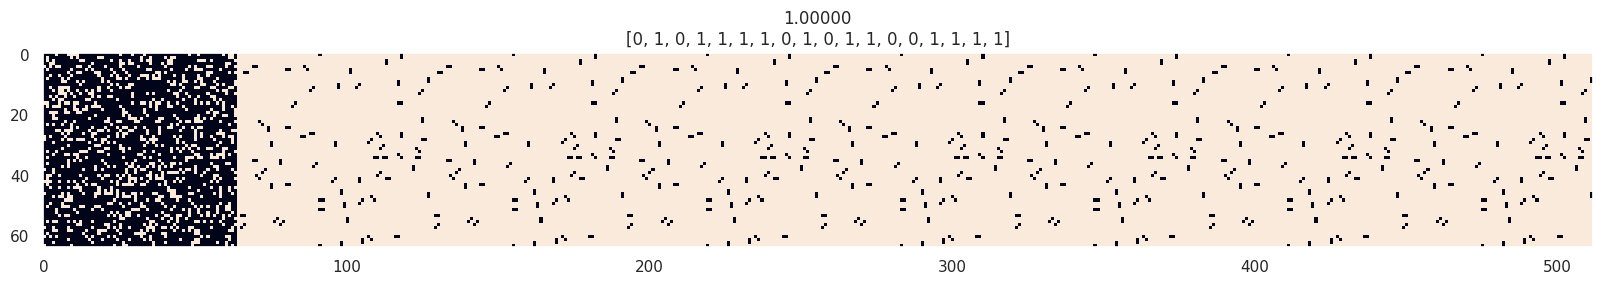

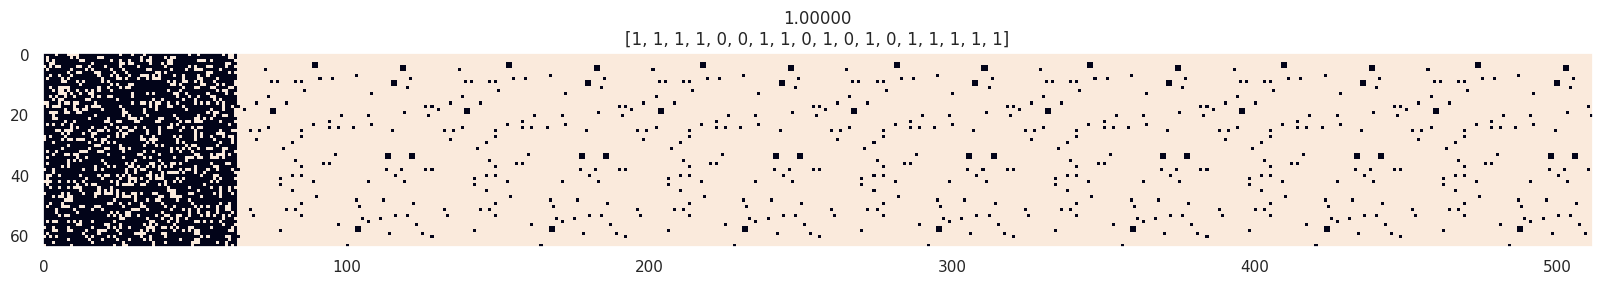

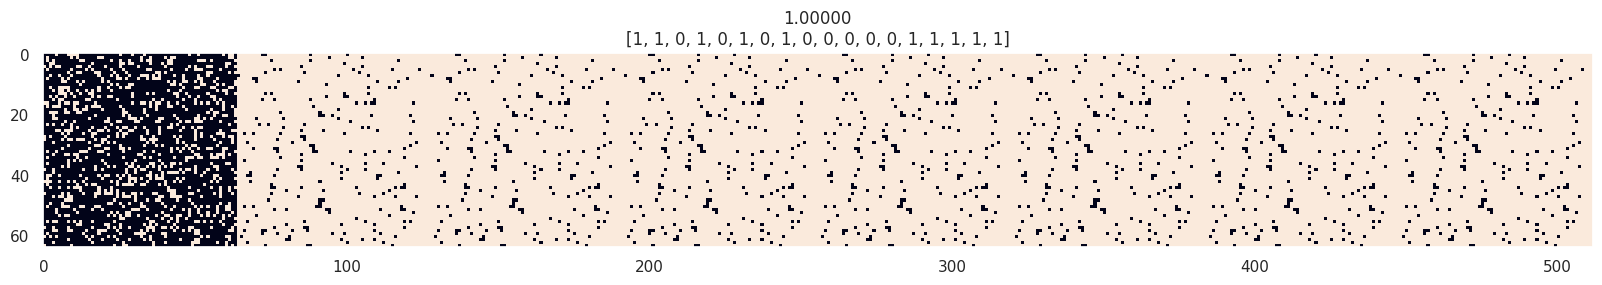

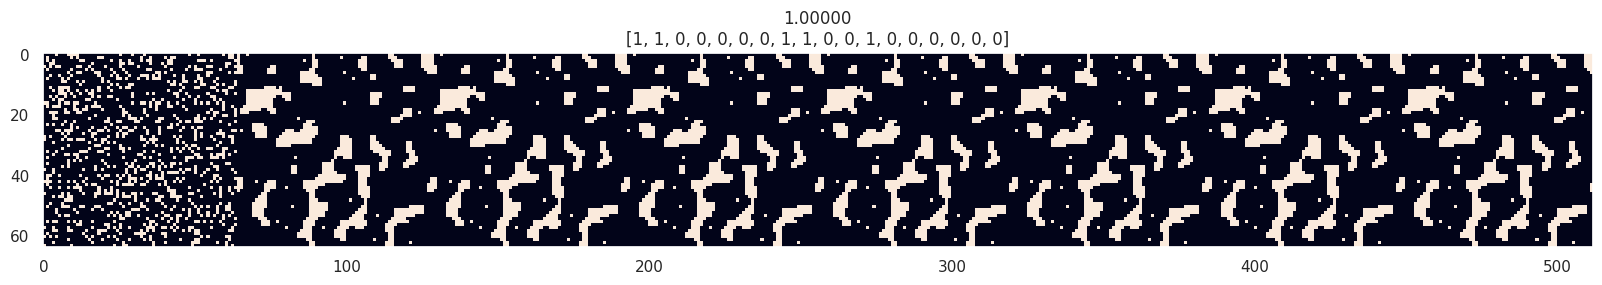

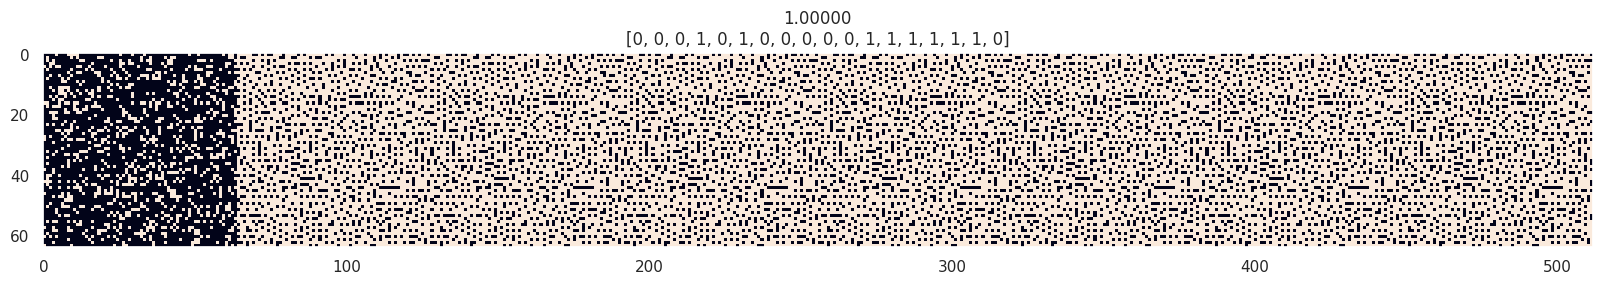

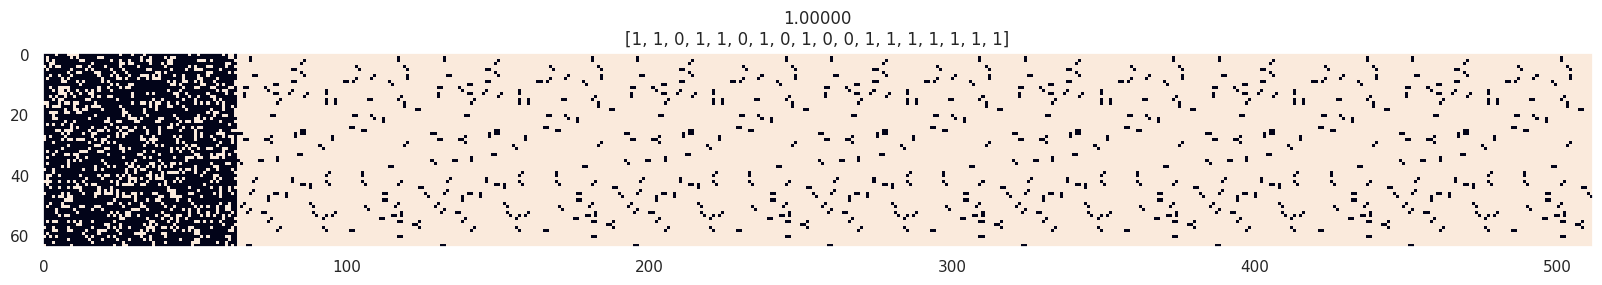

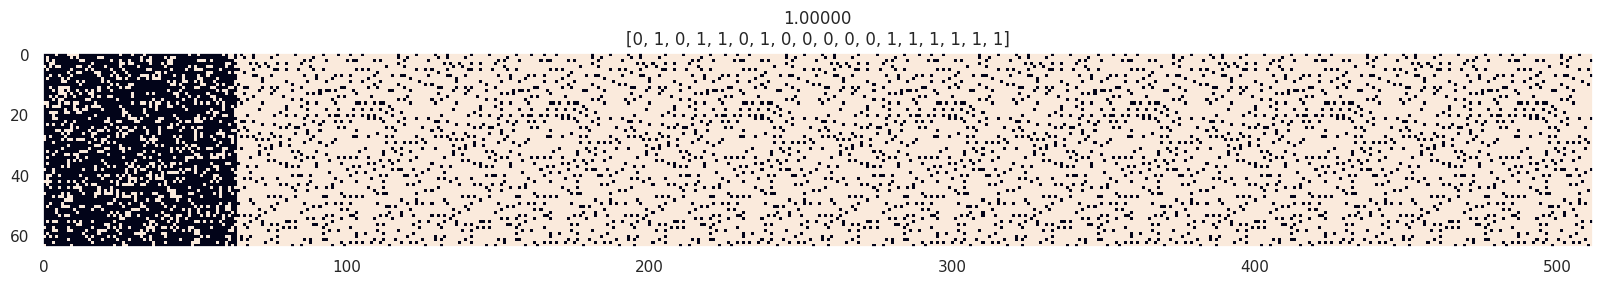

In [252]:
for i in tqdm(a.argsort()[-20:]):
    state_vid = eval_clip_complexity(data['params'][i])['state_vid']

    plt.figure(figsize=(20, 5))
    plt.imshow(rearrange(state_vid[64, ::64], "(R C) H W -> (R H) (C W)", R=1))
    plt.grid(False)
    plt.title(f"{a[i].item():.5f}\n{data['params'][i].tolist()}")
    plt.show()

In [218]:
for i in a.argsort()[:20]:
    print(data['params'][i], data['params'][i].sum())

[0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1] 9
[1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1] 9
[1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0] 6
[0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1] 8
[0 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1] 10
[0 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1] 10
[1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0] 11
[1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0] 8
[1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1] 9
[0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1] 12
[1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0] 11
[0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0] 3
[1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1] 10
[1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0] 11
[1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0] 13
[0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1] 8
[1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0] 8
[0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0] 7
[0 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1] 7
[1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0] 6
